In [51]:
import psycopg
import pandas as pd
import sys
import numpy as np
import csv
import matplotlib.pyplot as plt
import geopandas
import plotly.figure_factory as ff
import credentials

In [52]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

## The Report About Hospital Information For This Week 

In [53]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
week2 = '2022-10-21'

**1. Summary of how many hospital records were loaded in the most recent week, and how that compares to previous weeks.**

In [55]:
conn = psycopg.connect(
        host="sculptor.stat.cmu.edu", dbname=credentials.DB_USER,
        user=credentials.DB_USER, password=credentials.DB_PASSWORD"
    )

cur = conn.cursor()
cur.execute("SELECT collection_week, COUNT(collection_week) FROM Weekly_capacity_inform "
"WHERE collection_week <= %(week)s "
"GROUP BY collection_week "
"ORDER BY collection_week desc;", {"week": week2})
rows = cur.fetchall()
print(rows[0][1], "hospital records were loaded in the most recent week.")
for i in range(1,len(rows)):
    if rows[i][1] < rows[0][1]:
        print(rows[i][1], "hospital records were loaded in",rows[i][0],"week. "
    "Compared with",rows[i][0], "week, the number of records loaded this week is",
    rows[0][1]-rows[i][1],"more.")
    if rows[i][1] == rows[0][1]:
        print(rows[i][1], "hospital records were loaded in",rows[i][0],"week. "
    "Compared with",rows[i][0], "week, the number of records loaded this week is the same.")
    if rows[i][1] > rows[0][1]:
        print(rows[i][1], "hospital records were loaded in",rows[i][0],"week. "
    "Compared with",rows[i][0], "week, the number of records loaded this week is",
    rows[i][1]-rows[0][1],"less.")


4985 hospital records were loaded in the most recent week.
4995 hospital records were loaded in 2022-10-14 week. Compared with 2022-10-14 week, the number of records loaded this week is 10 less.
4996 hospital records were loaded in 2022-10-07 week. Compared with 2022-10-07 week, the number of records loaded this week is 11 less.
4997 hospital records were loaded in 2022-09-30 week. Compared with 2022-09-30 week, the number of records loaded this week is 12 less.
4996 hospital records were loaded in 2022-09-23 week. Compared with 2022-09-23 week, the number of records loaded this week is 11 less.


**2. Table summarizing the number of adult and pediatric beds available this week, the number used, and the number used by patients with COVID, compared to the 4 most recent weeks.**

In [56]:
from tabulate import tabulate
conn = psycopg.connect(
        host="sculptor.stat.cmu.edu", dbname=credentials.DB_USER,
        user=credentials.DB_USER, password=credentials.DB_PASSWORD"
    )

cur = conn.cursor()
cur.execute("SELECT collection_week, sum(all_adult_hospital_beds_7_day_avg), "
"sum(all_pediatric_inpatient_beds_7_day_avg), "
"sum(all_adult_hospital_inpatient_bed_occupied_7_day_coverage), "
"sum(all_pediatric_inpatient_bed_occupied_7_day_avg), "
"sum(inpatient_beds_used_covid_7_day_avg) "
"FROM Weekly_capacity_inform "
"WHERE collection_week <= %(week)s "
"and collection_week >= (%(week)s - 4 * integer '7') "
"GROUP BY collection_week "
"ORDER BY collection_week desc", {"week": week2})
rows = cur.fetchall()
my_table = pd.DataFrame(rows)

In [57]:
my_table = my_table.rename(columns = {0: 'collection week', 1: 'adult beds available',
2: 'pediatric beds available', 3: 'adult beds used', 4: 'pediatric beds used', 
5: 'the number used by patients with COVID'})
my_table.insert(loc=2,
          column = 'difference between adult beds available',
          value = my_table.iloc[0,1]- my_table.iloc[:,1])
my_table.insert(loc=4,
          column = 'difference between pediatric beds available',
          value = my_table.iloc[0,3]- my_table.iloc[:,3])
my_table.insert(loc=6,
          column = 'difference between adult beds used',
          value = my_table.iloc[0,5]- my_table.iloc[:,5]) 
my_table.insert(loc=8,
          column = 'difference between pediatric beds used',
          value = my_table.iloc[0,7]- my_table.iloc[:,7])
my_table.insert(loc=10,
          column = 'difference between the number used by patients with COVID',
          value = my_table.iloc[0,9]- my_table.iloc[:,9])  

In [58]:
my_table.style.set_properties(my_table["collection week"], **{'width': '300px', 'text-align':'center'})
my_table

,collection week,adult beds available,difference between adult beds available,pediatric beds available,difference between pediatric beds available,adult beds used,difference between adult beds used,pediatric beds used,difference between pediatric beds used,the number used by patients with COVID,difference between the number used by patients with COVID
0,2022-10-21,414880.3,0.0,39882.2,0.0,34376,0,29706.5,0.0,24116.8,0.0
1,2022-10-14,412939.0,1941.3,39711.6,170.6,34841,-465,28799.0,907.5,23695.5,421.3
2,2022-10-07,415465.4,-585.1,39796.8,85.4,34886,-510,28285.8,1420.7,23689.3,427.5
3,2022-09-30,416279.4,-1399.1,39804.7,77.5,34852,-476,28042.8,1663.7,24142.5,-25.7
4,2022-09-23,413589.5,1290.8,39605.5,276.7,34832,-456,27778.1,1928.4,25600.6,-1483.8


**3. A table summarizing the fraction of beds currently in use by hospital quality rating, so we can compare high-quality and low-quality hospitals.**

In [59]:
conn = psycopg.connect(
        host="sculptor.stat.cmu.edu", dbname=credentials.DB_USER,
        user=credentials.DB_USER, password=credentials.DB_PASSWORD"
    )

cur = conn.cursor()
'''cur.execute("SELECT quality_rating.hospital_overall_rating, "
            "AVG(weekly_capacity_inform.all_adult_hospital_inpatient_bed_occupied_7_day_coverage), "
            "AVG(weekly_capacity_inform.all_pediatric_inpatient_bed_occupied_7_day_avg), "
            "AVG(weekly_capacity_inform.all_adult_hospital_inpatient_bed_occupied_7_day_coverage "
            "+ weekly_capacity_inform.all_pediatric_inpatient_bed_occupied_7_day_avg) "
            "FROM weekly_capacity_inform "
            "JOIN quality_rating on weekly_capacity_inform.hospital_pk = quality_rating.facility_ID "
            "GROUP BY quality_rating.hospital_overall_rating "
            "ORDER BY quality_rating.hospital_overall_rating desc")'''

my_table_3 = pd.read_sql_query("SELECT quality_rating.hospital_overall_rating, "
            "AVG(weekly_capacity_inform.all_adult_hospital_inpatient_bed_occupied_7_day_coverage / "
            "weekly_capacity_inform.all_adult_hospital_beds_7_day_avg) AS adult_beds_occupied_fraction, "
            "AVG(weekly_capacity_inform.all_pediatric_inpatient_bed_occupied_7_day_avg / "
            "weekly_capacity_inform.all_pediatric_inpatient_beds_7_day_avg) AS pediatric_beds_occupied_fraction, "
            "AVG((weekly_capacity_inform.all_adult_hospital_inpatient_bed_occupied_7_day_coverage "
            "+ weekly_capacity_inform.all_pediatric_inpatient_bed_occupied_7_day_avg) / "
            "(weekly_capacity_inform.all_adult_hospital_beds_7_day_avg + weekly_capacity_inform.all_pediatric_inpatient_beds_7_day_avg))"
            "AS all_beds_occupied_fraction "
            "FROM weekly_capacity_inform "
            "JOIN quality_rating on weekly_capacity_inform.hospital_pk = quality_rating.facility_ID "
            "AND weekly_capacity_inform.all_adult_hospital_inpatient_bed_occupied_7_day_coverage IS NOT NULL "
            "AND weekly_capacity_inform.all_adult_hospital_beds_7_day_avg > 0 "
            "AND weekly_capacity_inform.all_pediatric_inpatient_beds_7_day_avg > 0 "
            "GROUP BY quality_rating.hospital_overall_rating "
            "ORDER BY quality_rating.hospital_overall_rating desc", conn)
my_table_3 = my_table_3.drop(0)
my_table_3

,hospital_overall_rating,adult_beds_occupied_fraction,pediatric_beds_occupied_fraction,all_beds_occupied_fraction
1,5.0,0.037422,0.576340,0.068946
2,4.0,0.033346,0.655894,0.079387
3,3.0,0.035358,0.618320,0.074545
4,2.0,0.031635,0.608289,0.067012
5,1.0,0.026576,0.580410,0.063862


**4. Plot of the total number of hospital beds used per week, over all time, split into all cases and COVID cases.**

* **The table containing specific total number of hospital beds used per week, over all time, split into all cases and COVID cases.**

In [60]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML

HTML("""
<style>
 {
    display: table-cell;
    text-align: center;
   .output_png vertical-align: middle;
}
</style>
""")

conn = psycopg.connect(
        host="sculptor.stat.cmu.edu", dbname=credentials.DB_USER,
        user=credentials.DB_USER, password=credentials.DB_PASSWORD"
    )

cur = conn.cursor()
cur = conn.execute("SELECT collection_week, "
                  "SUM(all_adult_hospital_inpatient_bed_occupied_7_day_coverage "
                  "+ all_pediatric_inpatient_bed_occupied_7_day_avg), "
                  "SUM(inpatient_beds_used_covid_7_day_avg) FROM Weekly_capacity_inform "
                  "WHERE collection_week <= %(week)s "
                  "GROUP BY collection_week "
                  "ORDER BY collection_week desc", {'week': week2})
rows = cur.fetchall()
my_table_4 = pd.DataFrame(rows)
my_table_4 = my_table_4.rename(columns = {0: "collection_week", 1:"all_cases_beds_used_per_week", 2:"covid_cases_beds_used_per_week"})
my_table_4
my_table_4['all_cases_beds_used_per_week'] = my_table_4['all_cases_beds_used_per_week'].astype(float)
my_table_4['covid_cases_beds_used_per_week'] = my_table_4['covid_cases_beds_used_per_week'].astype(float)
display(my_table_4)

,collection_week,all_cases_beds_used_per_week,covid_cases_beds_used_per_week
0,2022-10-21,59729.5,24116.8
1,2022-10-14,59325.0,23695.5
2,2022-10-07,58802.8,23689.3
3,2022-09-30,58581.8,24142.5
4,2022-09-23,58174.1,25600.6


* **The plot**

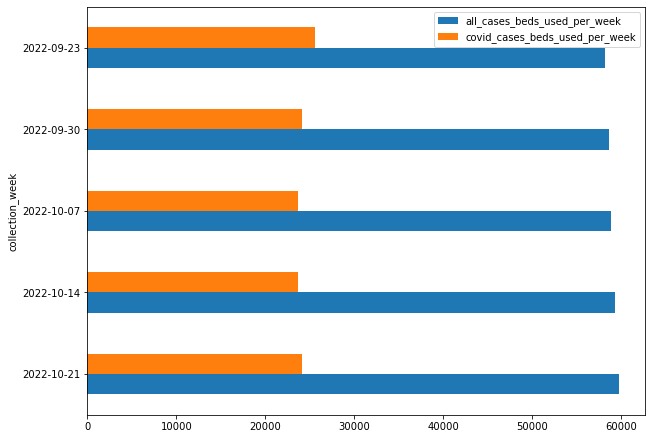

In [61]:
my_table_4.plot.barh(x= 'collection_week', figsize=(10, 7.5))
plt.show()

**5. A map showing the number of COVID cases by state.**

* **The table containing specific number of COVID cases by state.**

In [62]:
conn = psycopg.connect(
        host="sculptor.stat.cmu.edu", dbname=credentials.DB_USER,
        user=credentials.DB_USER, password=credentials.DB_PASSWORD"
    )

cur = conn.cursor()

'''cur.execute("SELECT left(Hospital_geographic_infor_hhs.fips_code, -5) AS fips_code, "
            "sum(Weekly_capacity_inform.inpatient_beds_used_covid_7_day_avg) FROM Weekly_capacity_inform "
            "JOIN Hospital_geographic_infor_hhs ON weekly_capacity_inform.hospital_pk = Hospital_geographic_infor_hhs.hospital_pk "   
            "GROUP BY left(Hospital_geographic_infor_hhs.fips_code, -5) "
            "ORDER BY fips_code asc;")
rows = cur.fetchall()
print(rows)'''
my_table_5 = pd.read_sql_query("SELECT Hospital_geographic_infor_quality.state AS state_code, "
            "SUM(Weekly_capacity_inform.inpatient_beds_used_covid_7_day_avg) FROM Weekly_capacity_inform "
            "JOIN Hospital_geographic_infor_quality ON weekly_capacity_inform.hospital_pk = Hospital_geographic_infor_quality.facility_ID "   
            "GROUP BY Hospital_geographic_infor_quality.state;", conn)
my_table_5 = my_table_5.rename(columns = {'sum': 'number of COVID cases'})

my_table_8 = pd.read_sql_query("SELECT left(Hospital_geographic_infor_hhs.fips_code, -5) AS fips_code, "
            "sum(Weekly_capacity_inform.inpatient_beds_used_covid_7_day_avg) FROM Weekly_capacity_inform "
            "JOIN Hospital_geographic_infor_hhs ON weekly_capacity_inform.hospital_pk = Hospital_geographic_infor_hhs.hospital_pk "   
            "GROUP BY left(Hospital_geographic_infor_hhs.fips_code, -5) "
            "ORDER BY fips_code asc;", conn)
my_table_8 = my_table_8.dropna()

my_table_5

,state_code,number of COVID cases
0,CA,8996.6
1,NH,537.1
2,OR,1490.9
3,TX,7002.1
4,ND,246.7
5,PR,687.7
6,NV,549.7
7,OH,5179.4
8,KY,1703.4
9,GU,8.4


In [63]:
my_table_8 = my_table_8.rename(columns = {'fips_code':'state_code', 'sum': 'number of COVID cases'})
my_table_8['state_code'] = my_table_8['state_code'].astype(str)

* **The map**

In [64]:
import plotly.express as px
fig = px.choropleth(my_table_5,
                    locations='state_code', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='number of COVID cases',
                    color_continuous_scale="Viridis_r",
                    
                    )
fig.show()

**6. Table of the states in which the number of cases has increased by the most since last week**

In [65]:
conn = psycopg.connect(
        host="sculptor.stat.cmu.edu", dbname=credentials.DB_USER,
        user=credentials.DB_USER, password=credentials.DB_PASSWORD"
    )

cur = conn.cursor()
cur.execute("select Hospital_geographic_infor_quality.state, collection_week, "
"sum(inpatient_beds_used_covid_7_day_avg)-lag(sum(inpatient_beds_used_covid_7_day_avg)) "
"over (partition by Hospital_geographic_infor_quality.state order by collection_week) "
"as increase_number_COVID from weekly_capacity_inform "
"JOIN Hospital_geographic_infor_quality ON weekly_capacity_inform.hospital_pk = "
"Hospital_geographic_infor_quality.facility_ID "
"WHERE collection_week <= %(week)s "
"AND collection_week >= (%(week)s - 1 * integer '7') "
"GROUP BY Hospital_geographic_infor_quality.state, collection_week "
"ORDER BY increase_number_COVID desc", {'week': week2})
rows = cur.fetchall()
my_table_6 = pd.DataFrame(rows)
my_table_6 = my_table_6.dropna()
my_table_6 = my_table_6.rename(columns = {0: "state", 1:"collection_week", 2:"increase_number_covid"})
my_table_6 = my_table_6.set_index('state')
my_table_6

,collection_week,increase_number_covid
state,,
IL,2022-10-21,133.3
WI,2022-10-21,81.4
OH,2022-10-21,79.5
IN,2022-10-21,67.8
MN,2022-10-21,65.9
AZ,2022-10-21,64.3
PA,2022-10-21,52.0
MO,2022-10-21,50.1
NY,2022-10-21,40.6


**7. Graphs of hospital utilization (the percent of available beds being used) by type of hospital (private or public), over time**

* **The table containing specific hospital utilization by type of hospital over time**

In [66]:
import warnings
warnings.filterwarnings('ignore')
conn = psycopg.connect(
        host="sculptor.stat.cmu.edu", dbname=credentials.DB_USER,
        user=credentials.DB_USER, password=credentials.DB_PASSWORD"
    )

cur = conn.cursor()
cur.execute("select Hospital_type_infor.hospital_ownership, "
"collection_week, AVG((weekly_capacity_inform.all_adult_hospital_inpatient_bed_occupied_7_day_coverage "
"+ weekly_capacity_inform.all_pediatric_inpatient_bed_occupied_7_day_avg) / "
"(weekly_capacity_inform.all_adult_hospital_beds_7_day_avg + "
"weekly_capacity_inform.all_pediatric_inpatient_beds_7_day_avg)) AS all_beds_occupied_fraction " 
"FROM weekly_capacity_inform "
"JOIN hospital_type_infor ON weekly_capacity_inform.hospital_pk = hospital_type_infor.facility_ID "
"AND weekly_capacity_inform.all_adult_hospital_inpatient_bed_occupied_7_day_coverage IS NOT NULL "
"AND weekly_capacity_inform.all_adult_hospital_beds_7_day_avg > 0 "
"AND weekly_capacity_inform.all_pediatric_inpatient_beds_7_day_avg > 0 "
"WHERE collection_week <= %(week)s "
"GROUP BY Hospital_type_infor.hospital_ownership, collection_week "
"ORDER BY collection_week desc;", {'week': week2})
rows = cur.fetchall()
my_table_7 = pd.DataFrame(rows)
my_table_7 = my_table_7.rename(columns = {0: "hospital_ownership", 1: "collection_week", 2:"all_beds_occupied_fraction"})
my_table_7['all_beds_occupied_fraction'] = my_table_7['all_beds_occupied_fraction'].astype(float)
my_table_7

,hospital_ownership,collection_week,all_beds_occupied_fraction
0,Physician,2022-10-21,0.124711
1,Voluntary non-profit - Private,2022-10-21,0.125605
2,Proprietary,2022-10-21,0.102291
3,Government - Federal,2022-10-21,NaN
4,Government - Local,2022-10-21,0.075838
5,Voluntary non-profit - Church,2022-10-21,0.084230
6,Government - State,2022-10-21,0.177721
7,Government - Hospital District or Authority,2022-10-21,0.076652
8,Voluntary non-profit - Other,2022-10-21,0.091657
9,Proprietary,2022-10-14,0.098150


* **Graph**

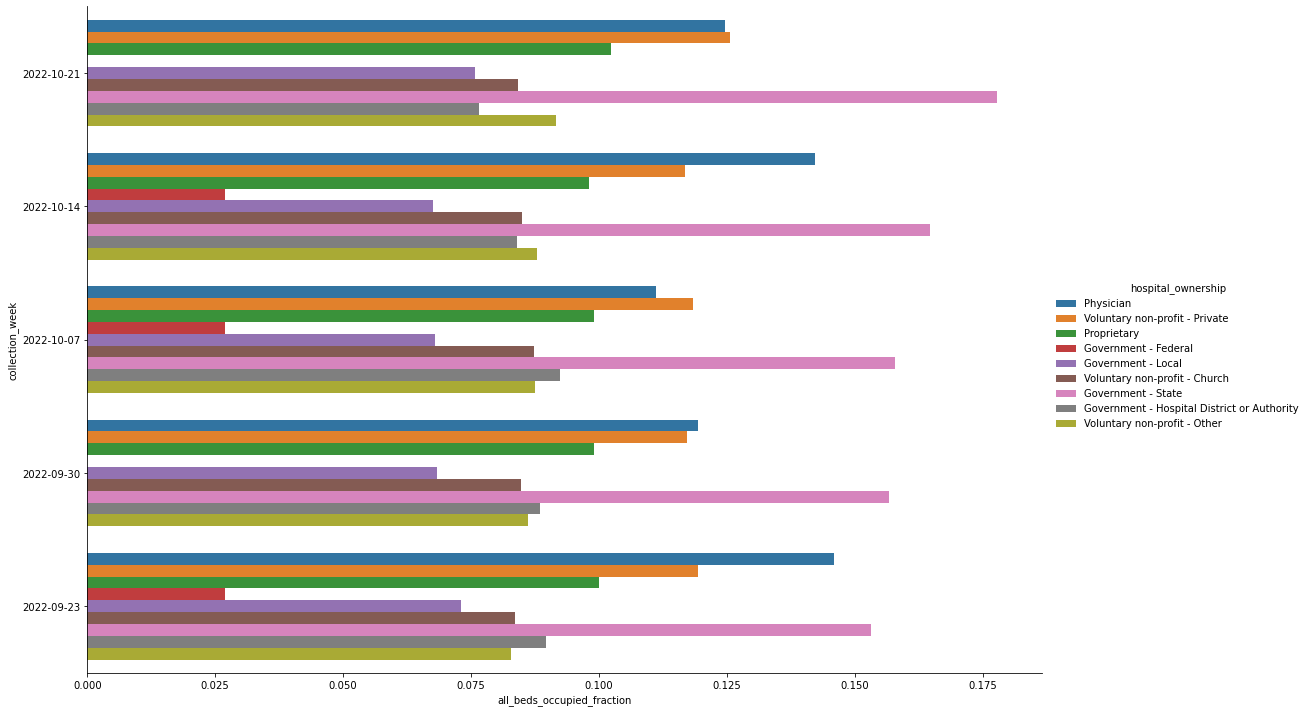

In [67]:
import seaborn as sns
sns.catplot(data=my_table_7, y ='collection_week', x = 'all_beds_occupied_fraction', hue='hospital_ownership', kind = 'bar',
            height=10, aspect=1.5)
plt.show()